* https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
from datetime import timedelta
from struct import unpack

In [2]:
csv = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3', delimiter=';', parse_dates=['jour'])
csv

,reg,cl_age90,jour,hosp,rea,rad,dc
0,1,0,2020-03-18,0,0,0,0
1,1,9,2020-03-18,0,0,0,0
2,1,19,2020-03-18,0,0,0,0
3,1,29,2020-03-18,0,0,0,0
4,1,39,2020-03-18,0,0,0,0
...,...,...,...,...,...,...,...
62959,94,59,2021-01-29,1,0,85,5
62960,94,69,2021-01-29,9,1,97,15
62961,94,79,2021-01-29,14,4,121,31
62962,94,89,2021-01-29,14,1,107,49


<AxesSubplot:xlabel='jour'>

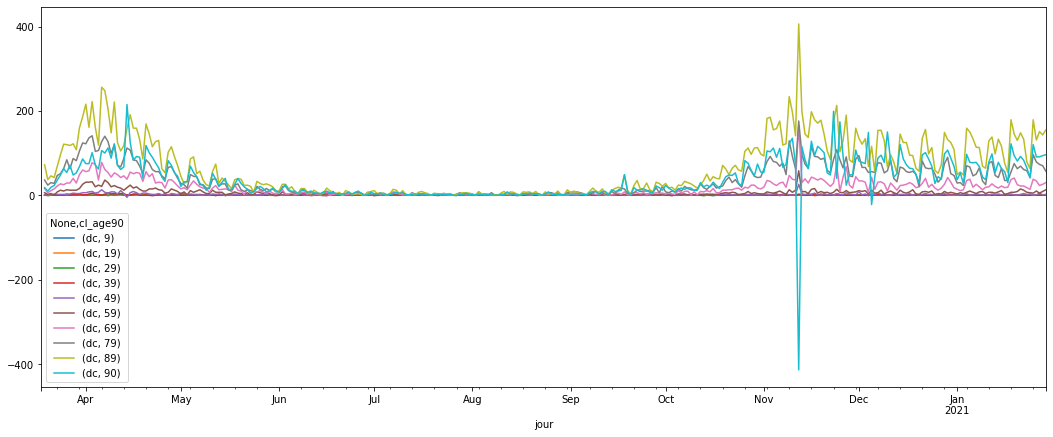

In [3]:
csv.groupby(['jour', 'reg', 'cl_age90']).sum().drop(columns=['hosp', 'rad', 'rea']).unstack('cl_age90').groupby('jour').sum().drop(columns=('dc',0)).diff().plot(figsize=(18,7))

In [4]:
xday=csv.jour.max()
yday = xday-timedelta(1)
day7 = xday-timedelta(7)
day30 = xday-timedelta(30)
(xday,yday,day7,day30)

(Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-01-28 00:00:00'),
 Timestamp('2021-01-22 00:00:00'),
 Timestamp('2020-12-30 00:00:00'))

In [5]:
# Répartition par age
def dx(n=None):
    if n is None:
        dp=csv[csv['cl_age90'] == 0]
    else:
        dp=csv[csv['cl_age90'] >= n]
    dp = pd.DataFrame(dp[dp['jour'] == xday].drop(columns=['reg','cl_age90','jour']).sum())
    if  n is None:
        dp.columns = ['*']
    else:
        dp.columns = ['>'+str(n)]
    return dp

def dxx(n=None):
    k = '>'+str(n)
    a = dx(n)
    b = dx()
    a['%'] = round(a[k]/b['*'],2)*100
    a[k]=b['*']-a[k]
    return a.astype(int)

res=pd.concat([dxx(i) for i in range(9, 99, 10)]+[dx()], axis=1)
res=res.rename(index={'hosp':'Hospitalisation', 'rea':'Réanimation', 'rad':'Retour domicile', 'dc':'Décès'})
res

,>9,%,>19,%,>29,%,>39,%,>49,%,>59,%,>69,%,>79,%,>89,%,*
Hospitalisation,227,99,263,99,331,99,545,98,908,97,1646,94,3598,87,7583,72,14117,48,27270
Réanimation,30,99,32,99,46,99,70,98,125,96,282,91,724,77,1647,47,2761,12,3120
Retour domicile,1777,99,3810,98,5946,97,13276,94,24815,89,41649,81,70116,69,108158,52,152499,32,223143
Décès,293,99,297,99,304,99,348,99,504,99,1004,98,2793,95,8226,84,19687,63,52891


In [6]:
res1=res.drop(columns='%')

<AxesSubplot:>

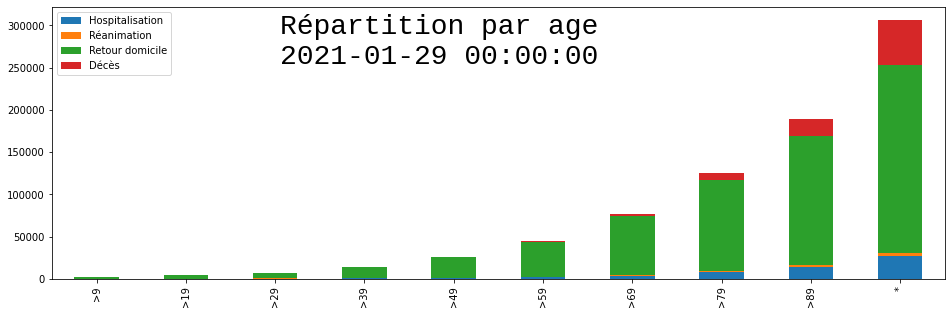

In [7]:
plot = res1.T.plot(kind='bar', figsize=(16, 5), stacked=True)
plot.text(280, 250, "Répartition par age\n"+str(xday), size=28, fontdict={'fontname':'liberation Mono'}, transform=None)
plot

<AxesSubplot:title={'center':'Décès in IDF'}, xlabel='jour'>

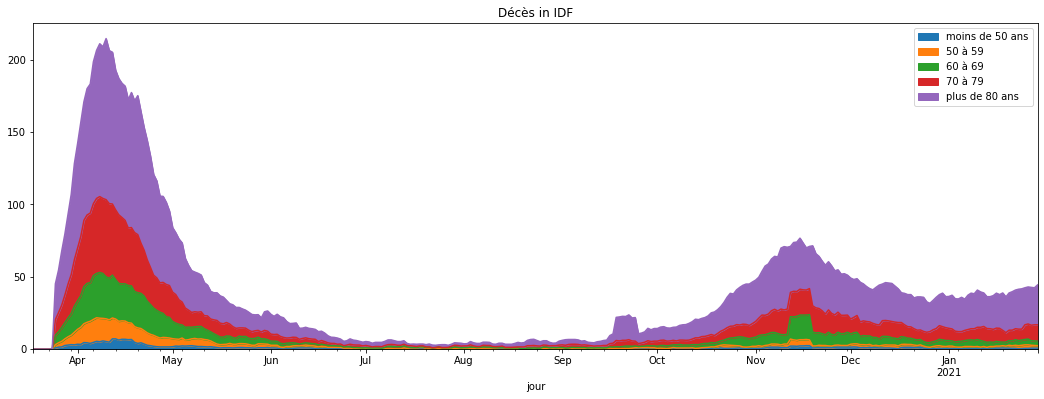

In [8]:
def group_cols(df, cols, gn):
    s = df[cols[0]]
    for c in cols[1:]:
        s = s + df[c]
    df[gn] = s
    return df.drop(columns=cols)

temp=csv[csv['reg'] == 11].drop(columns=['hosp','rad','rea','reg']).pivot(index='jour', columns='cl_age90')
temp = group_cols(temp, [('dc',9),('dc',19),('dc',29),('dc',39),('dc',49)], ('dc', 0))
temp = group_cols(temp, [('dc',89),('dc',90)], ('dc', 80))
temp = temp.reindex(sorted(temp.columns), axis=1)
temp.columns = ['moins de 50 ans', '50 à 59', '60 à 69', '70 à 79', 'plus de 80 ans']
temp.diff().rolling(7).mean().clip(0).plot.area(figsize=(18,6), stacked=True, title='Décès in IDF')

<AxesSubplot:title={'center':'Décès en France'}, xlabel='jour'>

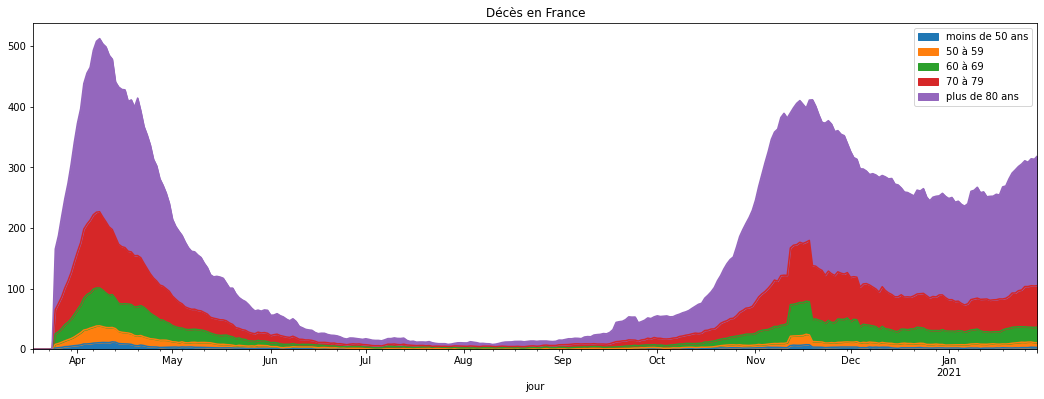

In [9]:
temp = csv.groupby(['jour','reg','cl_age90']).sum().drop(columns=['hosp','rad','rea']).unstack('cl_age90').groupby('jour').sum().diff()
temp = group_cols(temp, [('dc',9),('dc',19),('dc',29),('dc',39),('dc',49)], ('dc', 0))
temp = group_cols(temp, [('dc',89),('dc',90)], ('dc', 80))
temp = temp.reindex(sorted(temp.columns), axis=1)
#print(temp.columns)
temp.columns = ['moins de 50 ans', '50 à 59', '60 à 69', '70 à 79', 'plus de 80 ans']
temp.rolling(7).mean().clip(0).plot.area(figsize=(18,6), title='Décès en France')

,moins de 50 ans,50 à 59,60 à 69,70 à 79,plus de 80 ans
jour,,,,,
2020-03-18,NaN,NaN,NaN,NaN,NaN
2020-03-19,2.0,6.0,16.0,36.0,90.0
2020-03-20,-1.0,2.0,6.0,24.0,47.0
2020-03-21,0.0,4.0,11.0,30.0,65.0
2020-03-22,4.0,0.0,15.0,28.0,65.0
...,...,...,...,...,...
2021-01-25,3.0,5.0,38.0,96.0,299.0
2021-01-26,2.0,10.0,34.0,79.0,222.0
2021-01-27,6.0,5.0,23.0,73.0,242.0


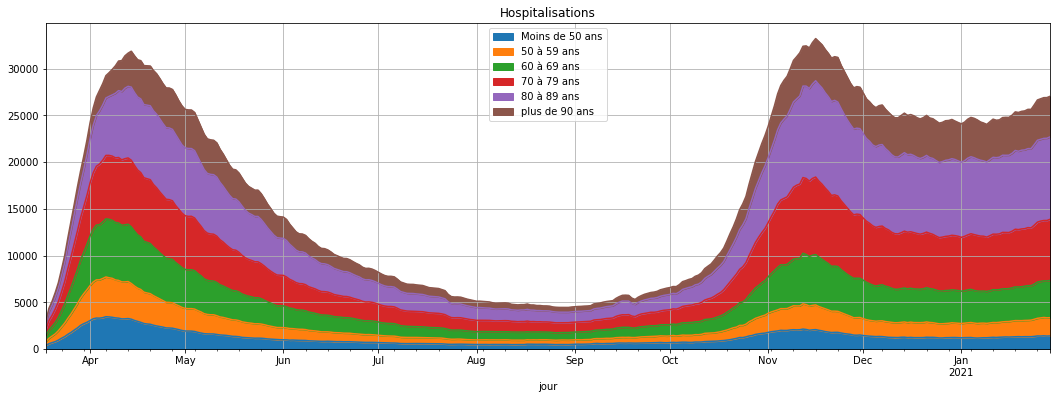

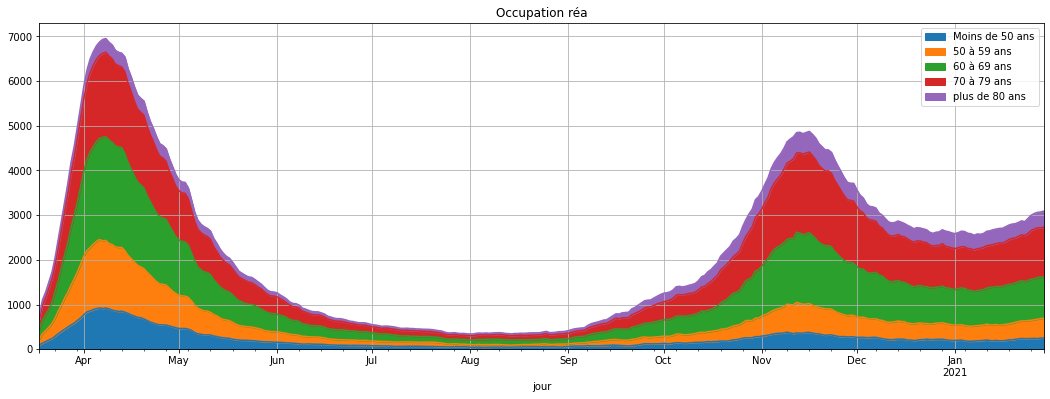

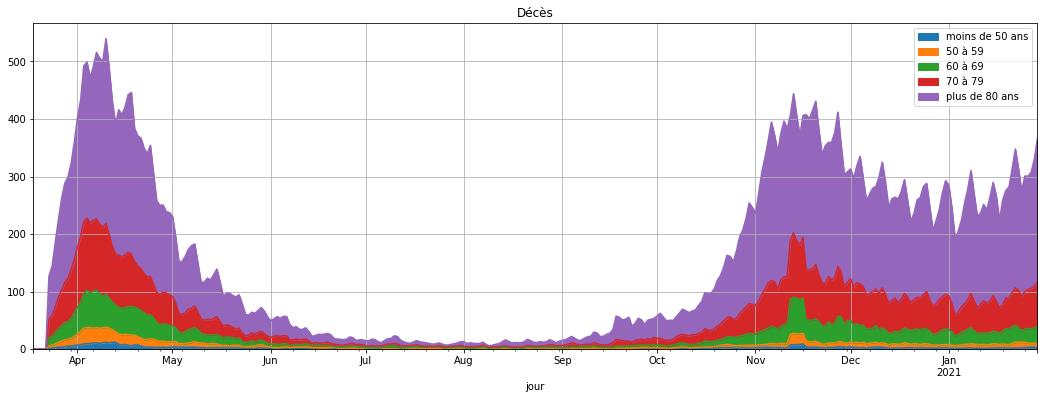

In [10]:
temp = csv.groupby(['jour','reg','cl_age90']).sum().drop(columns=['dc','rad','rea']).unstack('cl_age90').groupby('jour').sum()
temp.columns = [x for _,x in temp.columns]
temp = group_cols(temp, [9,19,29,39,49], 0)
temp = temp.reindex(sorted(temp.columns), axis=1)
temp.columns = ['Moins de 50 ans', '50 à 59 ans', '60 à 69 ans', '70 à 79 ans', '80 à 89 ans', 'plus de 90 ans']
temp.plot.area(figsize=(18,6), title='Hospitalisations', grid=True)

temp = csv.groupby(['jour','reg','cl_age90']).sum().drop(columns=['hosp','rad','dc']).unstack('cl_age90').groupby('jour').sum()
temp.columns = [x for _,x in temp.columns]
temp = group_cols(temp, [9,19,29,39,49], 0)
temp = group_cols(temp, [89,90], 99)
temp = temp.reindex(sorted(temp.columns), axis=1)
temp.columns = ['Moins de 50 ans', '50 à 59 ans', '60 à 69 ans', '70 à 79 ans', 'plus de 80 ans']
temp.plot.area(figsize=(18,6), title='Occupation réa', grid=True)

# smooth only vthe deaths and clip vas we get negative values.... resurection?
temp = csv.groupby(['jour','reg','cl_age90']).sum().drop(columns=['hosp','rad','rea']).unstack('cl_age90').groupby('jour').sum().diff()
temp = group_cols(temp, [('dc',9),('dc',19),('dc',29),('dc',39),('dc',49)], ('dc', 0))
temp = group_cols(temp, [('dc',89),('dc',90)], ('dc', 80))
temp = temp.reindex(sorted(temp.columns), axis=1)
#print(temp.columns)
temp.columns = ['moins de 50 ans', '50 à 59', '60 à 69', '70 à 79', 'plus de 80 ans']
temp.rolling(5).mean().clip(0).plot.area(figsize=(18,6), title='Décès', grid=True)
temp

In [11]:
# resurection in november?
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'gray'
    return 'color: %s' % color

regs = csv.groupby('reg')['reg'].count().index.to_list() # list of region
csv[(csv['reg'] != 0) & (csv['jour'].dt.month == 11)].groupby(['jour','reg','cl_age90'])\
    .sum()\
    .drop(columns=['hosp','rad','rea'])\
    .unstack('cl_age90')\
    .groupby('jour')\
    .sum()\
    .diff()\
    .fillna(0)\
    .apply(lambda s: s.astype(int))\
    .style.applymap(color_negative_red)

In [12]:
# https://fr.wikipedia.org/wiki/Codes_g%C3%A9ographiques_de_la_France
# 11: Ile de France
# 44: Grand Est
# 93: PACA
# 84: Auvergne Rhones Alpes
# ...
csv.groupby('reg')['reg'].count().index.to_list()

[1, 2, 3, 4, 6, 11, 24, 27, 28, 32, 44, 52, 53, 75, 76, 84, 93, 94]

In [13]:
csv[(csv['jour'] == xday) & (csv['cl_age90'] == 0)].drop(columns=['jour', 'cl_age90']).groupby('reg').sum().sort_values('dc').T

reg,2,6,4,3,94,1,53,24,52,28,75,76,27,93,32,44,84,11
hosp,14,54,19,45,52,51,690,1099,1021,1358,1500,1791,1801,3255,2535,2948,3843,5194
rea,3,4,3,13,6,4,46,135,95,117,204,243,170,404,285,323,417,648
rad,383,592,791,2125,553,793,3971,6495,7346,7182,9404,11835,12076,22274,20567,24763,32579,59414
dc,45,47,55,72,125,170,898,1644,1698,1860,2237,2592,3294,4487,5262,7118,7986,13301


<AxesSubplot:xlabel='cl_age90'>

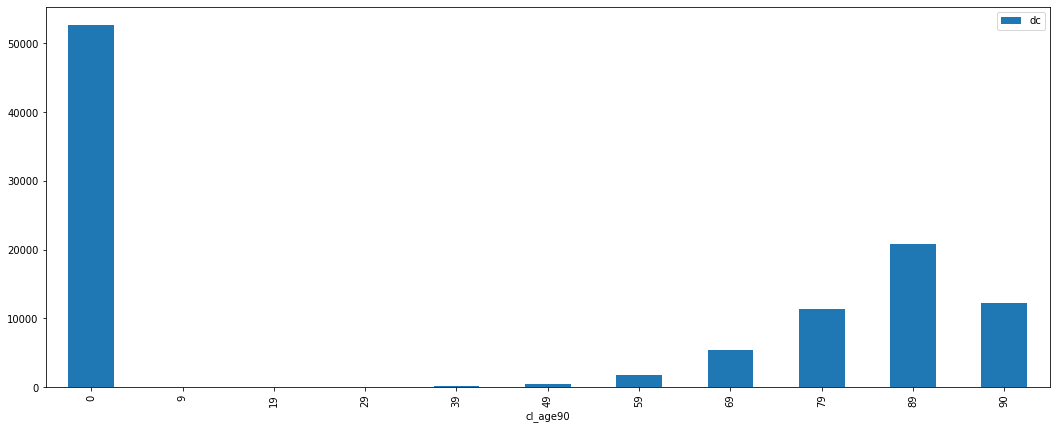

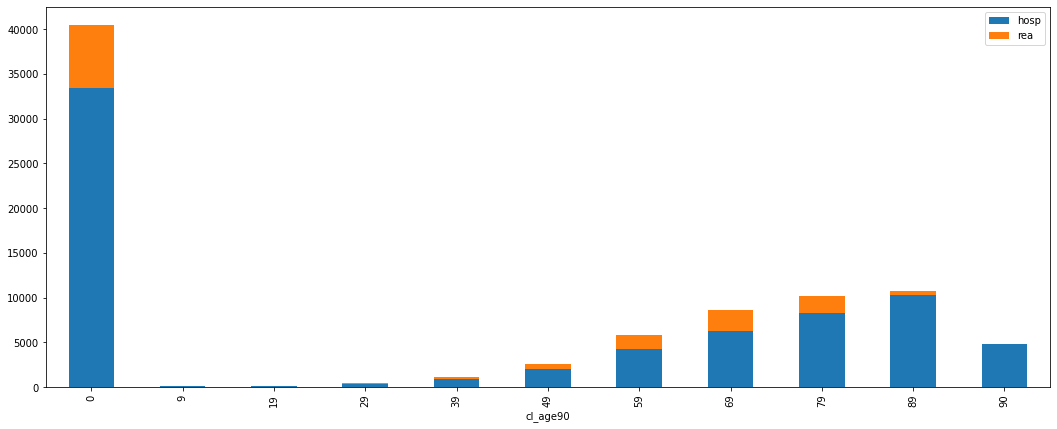

In [14]:
dc = csv.groupby(['jour', 'cl_age90']).sum().drop(columns=['reg', 'rad', 'rea', 'hosp']).unstack('cl_age90').diff().sum()
rea = csv.groupby(['jour', 'cl_age90']).sum().drop(columns=['reg', 'rad', 'dc', 'hosp']).unstack('cl_age90').max()
rad = csv.groupby(['jour', 'cl_age90']).sum().drop(columns=['reg', 'rea', 'dc', 'hosp']).unstack('cl_age90').diff().sum()
hosp = csv.groupby(['jour', 'cl_age90']).sum().drop(columns=['reg', 'rad', 'dc', 'rea']).unstack('cl_age90').max()
temp = pd.concat([dc], axis=0).unstack(['cl_age90']).T
temp.plot.bar(figsize=(18, 7), stacked=True)
temp = pd.concat([hosp, rea], axis=0).unstack(['cl_age90']).T
temp.plot.bar(figsize=(18, 7), stacked=True)